# Multi-class Dog Breed Classification
Multi-class image classification using Tensorflow 2.0 and Tensorflow Hub

## Data
https://www.kaggle.com/competitions/dog-breed-identification/overview

### TODO:
- Manipulate (crop, resize) or distort them (flip, rotate) to augment and enhance the training dataset. https://www.tensorflow.org/api_docs/python/tf/image
- "How to improve a TensorFlow 2.x image classification model?"
- "TensorFlow 2.x image classification best practices"
- "Transfer learning for image classification with TensorFlow 2.x"
- "Deep learning project examples with TensorFlow 2.x"

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from pathlib import Path
from datetime import date, datetime, timedelta, timezone
import numpy, pandas as pd, seaborn, os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, MaxPooling2D, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
labels_csv = pd.read_csv("data/dog-breed-identification/labels.csv") # the breeds for the images in the train set
print(labels_csv.describe())
print(labels_csv.head());

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


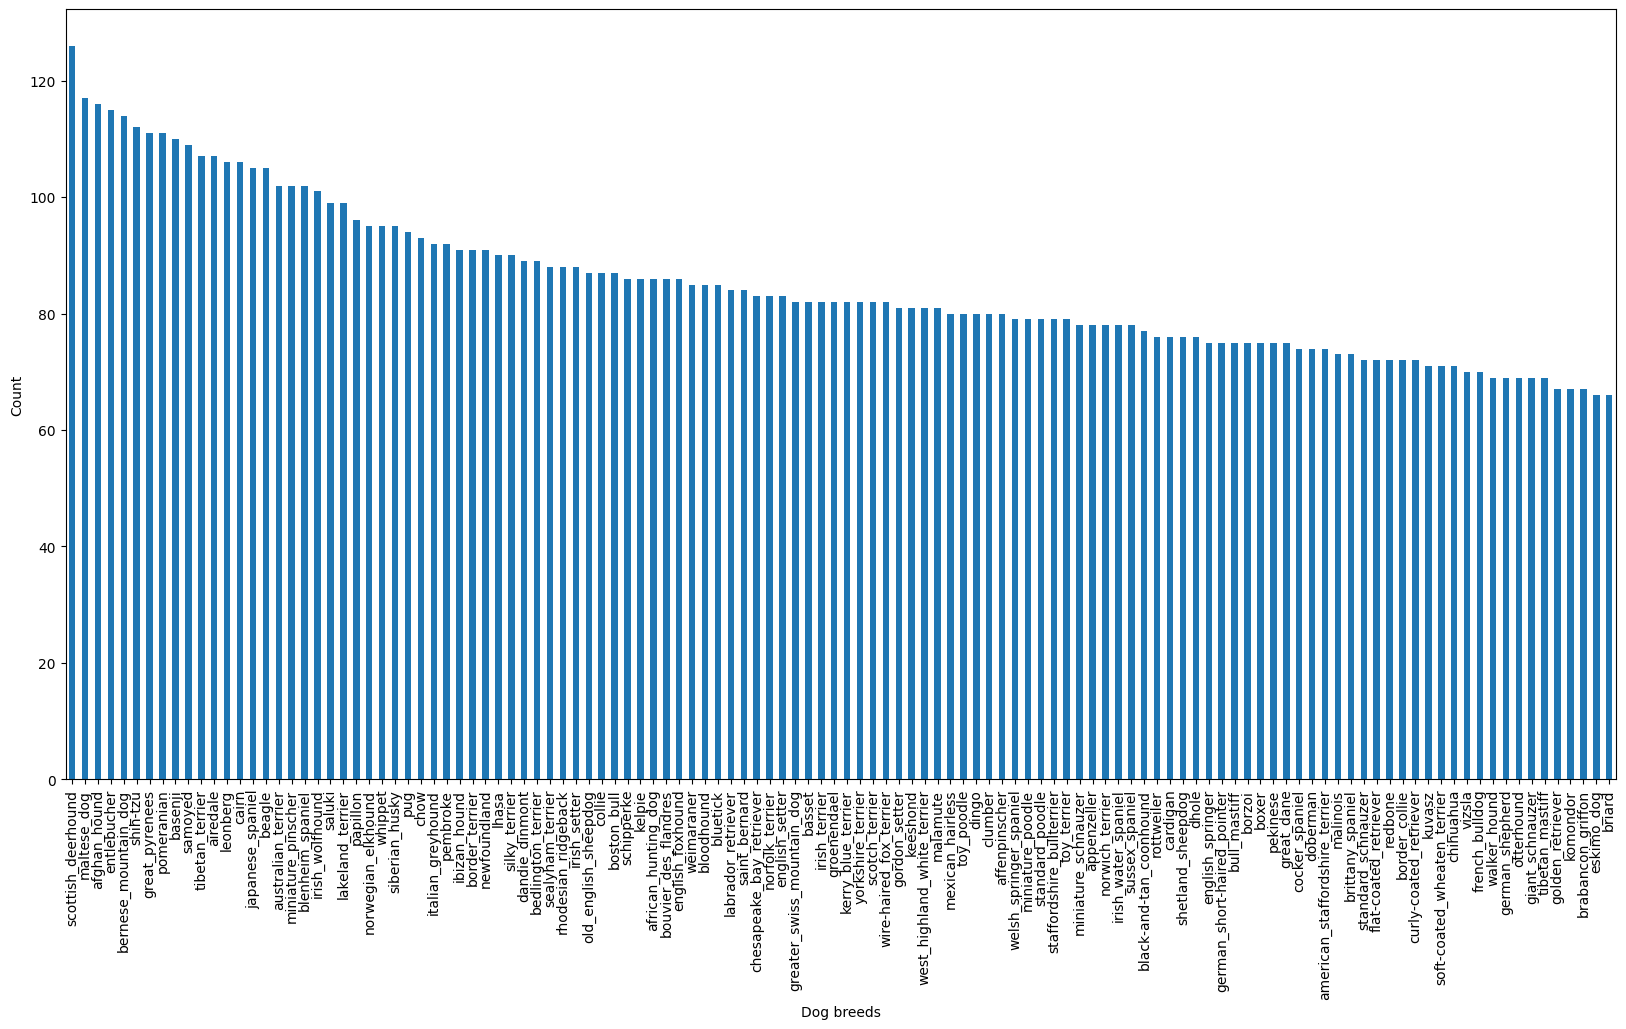

In [2]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10)) # figsize = (width, height)
plt.xlabel("Dog breeds");
plt.ylabel("Count");

In [3]:
train_filenames = [f"data/dog-breed-identification/train/{f}.jpg" for f in labels_csv["id"]]
labels = labels_csv["breed"].to_numpy()
assert len(labels) == len(train_filenames)
assert len(os.listdir("data/dog-breed-identification/train/")) == len(train_filenames)
print(f"train dataset size: {len(labels)}")
train_filenames[:10]
unique_breeds = numpy.unique(labels)
print(f"{len(unique_breeds)} unique breeds")
unique_breeds

train dataset size: 10222
120 unique breeds


array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

## Label Encoding
- Turn every label into one-hot encoded boolean array
- This effectively encodes the string labels. The prediction probabilities will follow the order of this encoded array for the probability to label mapping.

In [4]:
bool_labels = [l == unique_breeds for l in labels] # Y
assert len(unique_breeds) == len(bool_labels[0])
bool_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [5]:
# Example: Turn bool array into integer array
print(labels[0]) # original label
index = numpy.where(unique_breeds == labels[0])
print(f"Index of {labels[0]} is {index}: {unique_breeds[index[0][0]]}") # Index of the breed
print(f"{labels[0]} is True at {bool_labels[0].argmax()}")

boston_bull
Index of boston_bull is (array([19]),): boston_bull
boston_bull is True at 19


In [6]:
# Train, validation and test datasets
X = train_filenames
Y = bool_labels
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
# Split the training dataset into training and validation of NUM_IMAGES total size
#X_train, X_validation, Y_train, Y_validation = train_test_split(X[:NUM_IMAGES], Y[:NUM_IMAGES], test_size=0.2)
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)
print(f"X_train: {len(X_train)}, Y_train: {len(Y_train)}, X_validation: {len(X_validation)}, Y_validation: {len(Y_validation)}")
# Check out the training data (image file paths and labels)
#X_train[:5], Y_train[:2]
Y_train[:2]
#X_train_tensors = tf.constant(X_train)
#Y_train_tensors = tf.constant(Y_train)
#print(f"X_train_tensors: {X_train_tensors.shape}, Y_train_tensors: {Y_train_tensors.shape}")

X_train: 8177, Y_train: 8177, X_validation: 2045, Y_validation: 2045


[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [7]:
image = imread(train_filenames[42]) # read in an image
image.shape # (M, N, 4) (height, width, RGB+Apha)

(257, 350, 3)

In [8]:
# Process images into tensors
# Use the same image shape as this transfer model https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/140-224-classification
IMAGE_SIZE=224 # Try to use a square image.
IMG_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(f"IMG_SHAPE: {IMG_SHAPE}")
BATCH_SIZE=32

def ProcessImage(path: str, size=IMAGE_SIZE) -> tf.Tensor:
    """
    Process input image file content into a tensor.
    """
    img: tf.Tensor = tf.io.read_file(path)
    #print(f"img type: {type(img)}")
    # Turn the JPG image into numerical tensor with 3 colour channels (RGB)
    # https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg
    img = tf.image.decode_jpeg(img, channels=3)
    # Normalize the colour channel values from 0-255 to 0-1
    img = tf.image.convert_image_dtype(img, tf.float32) # https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype
    # Resize the image
    img = tf.image.resize(img, size=[size, size])
    return img

def get_image_label(path: str, label, size=IMAGE_SIZE):
    """
    Convenience function to pack 2 input parameters into a tuple.
    Return: (Image, label)
    """
    return ProcessImage(path, size), label

IMG_SHAPE: (224, 224, 3)


In [9]:
# Turn data into batches to fit into memory. Recommended batch size is 32.
# Data in the form of tensor tuple (image, label)
def create_data_batches(X, Y=None, batch_size=BATCH_SIZE, isValidation=False, isTest=False):
    """
    Creates batches of data out of image (X) and label (Y) pairs.
    Shuffle only if the input is training dataset.
    Accepts test dataset as input without labels.

    Input:
    X: list of file paths
    Y: One-hot encoded boolean labels
    """
    if isTest:
        print("Create test data batches...")
        data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # list
        return data.map(ProcessImage).batch(batch_size)
    elif isValidation:
        print("Create validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y))) # tuples of (path, label)
        return data.map(get_image_label).batch(batch_size)
    else:
        print("Create training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y)))  # tuples of (path, label)
        # Suffling simple data types especially with fewer dimensions is faster than shuffling the images with 3 dimension.
        return data.shuffle(len(X)).map(get_image_label).batch(batch_size)

In [10]:
train_data = create_data_batches(X_train, Y_train, BATCH_SIZE)
validation_data = create_data_batches(X_validation, Y_validation, BATCH_SIZE, isValidation=True)
# ((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
#  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
# (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
#  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))
train_data.element_spec, validation_data.element_spec

Create training data batches...
Create validation data batches...


I0000 00:00:1759056235.738769 1165742 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1970 MB memory:  -> device: 0, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [11]:
# Visualize data batches
def ShowDataBatch(images, labels):
    """
    Plot 25 images and their labels in the batch.
    """
    plt.figure(figsize=(10,10))
    for i in range(25):
        # Create 5x5 subplots
        ax = plt.subplot(5,5,i+1) # index starts at 1 in the upper-left corner
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis("off")

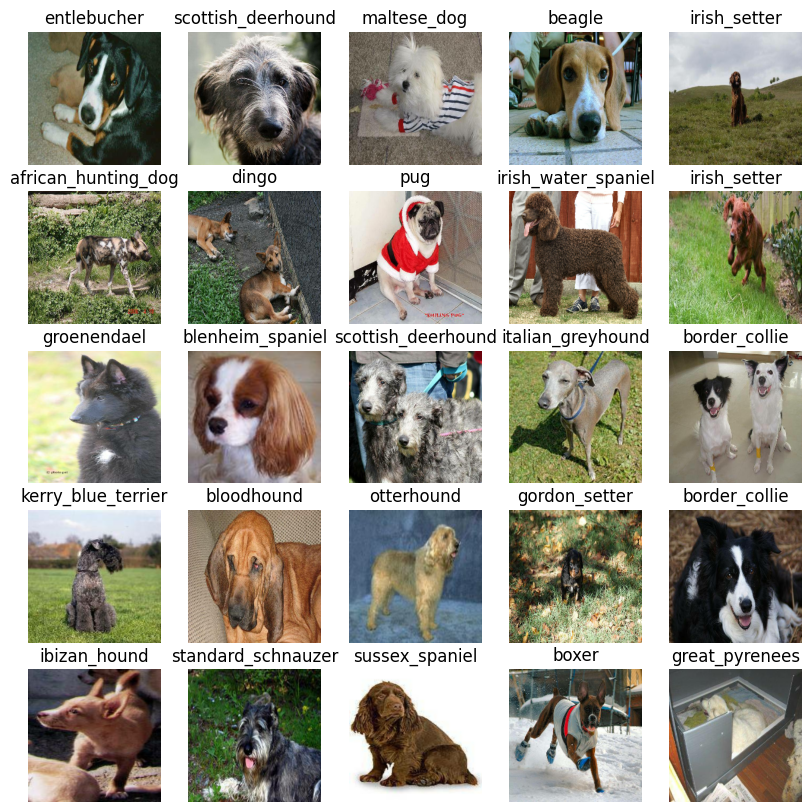

In [12]:
train_images, train_labels = next(train_data.as_numpy_iterator())
assert BATCH_SIZE == len(train_images)
assert BATCH_SIZE == len(train_labels)
ShowDataBatch(train_images, train_labels)

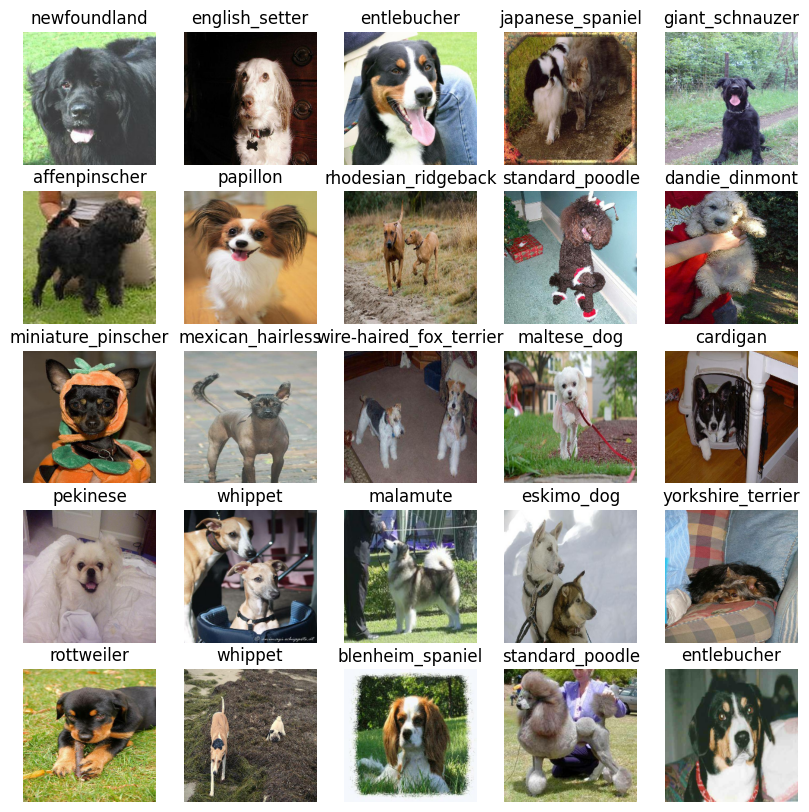

In [13]:
validation_images, validation_labels = next(validation_data.as_numpy_iterator())
assert BATCH_SIZE == len(validation_images)
assert BATCH_SIZE == len(validation_labels)
ShowDataBatch(validation_images, validation_labels)

In [52]:
# UNQ_C1
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    datagen = ImageDataGenerator(
        rotation_range=40, #
        width_shift_range=0.2, #
        height_shift_range=0.2, #
        shear_range=0.2, # deprecated
        zoom_range=0.2, #
        horizontal_flip=True, #
        fill_mode='nearest' #)
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential([
                            RandomFlip('horizontal'),
                            RandomRotation(0.2, "nearest"),
                            RandomTranslation(0.2, 0.2, "nearest"),
                            RandomZoom(0.2, 0.2, "nearest")
                            ])
    ### END CODE HERE
    return data_augmentation

In [53]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == (-0.2, 0.2), f"Rotation factor must be 0.2: {augmenter.layers[1].factor}"
#assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')


All tests passed!


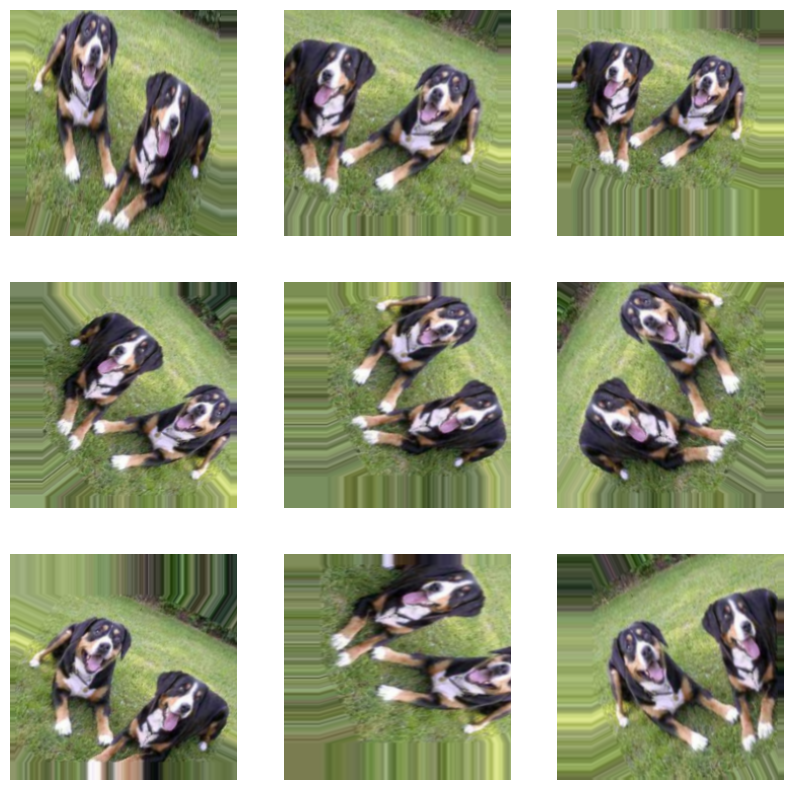

In [54]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
"""
https://stackoverflow.com/questions/68449103/tf-keras-preprocessing-image-dataset-from-directory-value-error-no-images-found
train_folder = "data/dog-breed-identification/train"
validation_folder = "data/dog-breed-identification/test"
train_dataset = image_dataset_from_directory(train_folder,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(validation_folder,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)
"""
train_dataset = train_data.prefetch(buffer_size=AUTOTUNE)

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = augmenter(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')

In [55]:
# UNQ_C2
# GRADED FUNCTION
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

def CreateModel(image_shape, output_shape, data_augmentation, learning_rate:float = 0.01):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    '''
    base_model = tf.keras.applications.MobileNetV3Large(input_shape=image_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights="imagenet")
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

    if data_augmentation:
        # create the input layer (Same as the imageNetv2 input size)
        inputs = tf.keras.Input(shape=image_shape)
        
        # apply data augmentation to the inputs
        x = data_augmentation(inputs)

        # data preprocessing using the same weights the model was trained on
        x = preprocess_input(x)
        
        # set training to False to avoid keeping track of statistics in the batch norm layer
        x = base_model(x, training=False) 
    else:
        x = base_model.output

    # add the new Multi-class classification layers
    # use global avg pooling to summarize the info in each channel
    x = GlobalMaxPooling2D(name="MaxPooling")(x)
    x = BatchNormalization()(x)

    # include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.2, name="FinalDropout")(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = Dense(output_shape, kernel_regularizer=l2(0.1))(x) # Linear activation
    
    model = tf.keras.Model(inputs, outputs) if data_augmentation else tf.keras.Model(base_model.input, outputs)
    model.name = "DogBreedsClassification"
    model.compile(optimizer=Adam(learning_rate),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model

## Train the model
### Tensorflow Callbacks
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

In [41]:
def PlotModelPerformance(history):
    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - accuracy: 0.0164 - loss: 6.7858 - val_accuracy: 0.0127 - val_loss: 4.8415
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.0177 - loss: 4.8245 - val_accuracy: 0.0244 - val_loss: 4.8197
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.0190 - loss: 4.8230 - val_accuracy: 0.0225 - val_loss: 4.8124
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.0186 - loss: 4.8222 - val_accuracy: 0.0240 - val_loss: 4.8210
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.0187 - loss: 4.8222 - val_accuracy: 0.0259 - val_loss: 4.8174
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.0225 - loss: 4.8191 - val_accuracy: 0.0249 - val_loss: 4.8185
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.0201 - loss: 4.8163 - val_accuracy: 0.0249 - val_loss: 4.8237

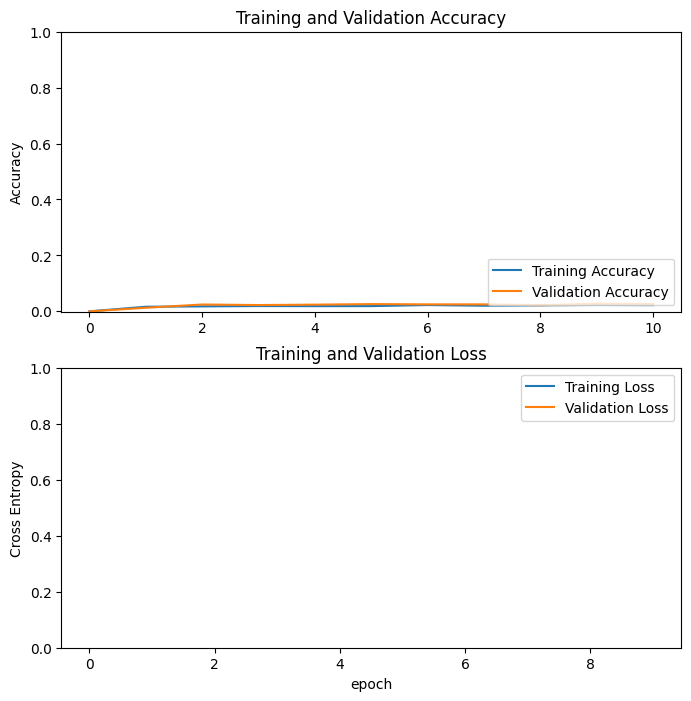

In [56]:
# Load the notebook extension
%load_ext tensorboard
NUM_EPOCHS = 10 #@param {type="slider", min:10, max:100, step=10}
def CreateTensorBoardCallback():
    # Create a log directory for storing TensorBoard logs
    logdir = Path(f"logs/dogbreed/{datetime.now().strftime("%Y-%m-%d-%H%M%S")}")
    return TensorBoard(logdir)

def CreateCircuitBreakerCallback(monitor:str="accuracy", patience:int = 3):
    """
    Early-stopping callback which could help prevent overfitting by stopping the training once certain evaluation metrics stop improving / start to plateau.
    """
    return EarlyStopping(monitor=monitor, patience=patience)

base_learning_rate = 0.001
data_augmentation = data_augmenter()

# Original base model
#model = CreateModel(IMG_SHAPE, len(unique_breeds), None, base_learning_rate)
# With data augmentation
model = CreateModel(IMG_SHAPE, len(unique_breeds), data_augmentation, base_learning_rate)
#model.summary()
tensorboard = CreateTensorBoardCallback()
circuit_breaker = CreateCircuitBreakerCallback("val_accuracy") # This is not orthogonal as it will affect both the bias (training vs bayes optimal error) and variance (Cross-validation vs training error).

# pipenv run tensorboard --logdir ZTM/logs/dogbreed
history = model.fit(x=train_data, epochs=NUM_EPOCHS, validation_data=validation_data, validation_freq=1, callbacks=[tensorboard])
PlotModelPerformance(history)

In [30]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(validation_data, verbose=1) # verbose shows us how long there is to go
predictions

64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step


array([[-0.29256505,  0.24526355,  0.02298005, ...,  0.0232919 ,
        -0.03093479,  0.1892802 ],
       [-0.29772174,  0.24152678,  0.02766347, ...,  0.02105363,
        -0.02843589,  0.1876963 ],
       [-0.27287778,  0.20716041,  0.03578863, ...,  0.01691688,
        -0.0199475 ,  0.17045544],
       ...,
       [-0.29196915,  0.23702998,  0.0270987 , ...,  0.01933414,
        -0.02507037,  0.18477939],
       [-0.29818013,  0.2464679 ,  0.0241242 , ...,  0.02163067,
        -0.02921821,  0.19024032],
       [-0.29888874,  0.24701867,  0.02614788, ...,  0.01896293,
        -0.02836372,  0.18902712]], shape=(2045, 120), dtype=float32)

In [31]:
def GetImageLabel(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label
    """
    assert len(unique_breeds) == len(prediction_probabilities)
    return unique_breeds[numpy.argmax(prediction_probabilities)]

# Extract elements of data from data batch
def ExtractBatch(data):
    """
    Takes a batched dataset of (image, label) tensors and return separate arrays of images and labels
    """
    images = []
    labels = []
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[numpy.argmax(label)])
    return images, labels

def ValidatePrediction(prediction_probabilities, truth, image):
    label = GetImageLabel(prediction_probabilities)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    colour = "green" if label == truth else "red"
    plt.title(f"{label} {numpy.max(prediction_probabilities) * 100 :2.0f}% - {truth}", color = colour)

def ValidateTop10Predictions(prediction_probabilities, truth):
    # Get the top-10 prediction probabilities in descending order.
    top10_indices = prediction_probabilities.argsort()[-10:][::-1]
    top10_probabilities = prediction_probabilities[top10_indices]
    top10_labels = unique_breeds[top10_indices]
    #plt.imshow(image)
    #plt.xticks([])
    #plt.yticks([])
    #colour = "green" if label == truth else "red"
    #plt.title(f"{label} {numpy.max(prediction_probabilities) * 100 :2.0f}% - {truth}", colour = colour)
    plots = plt.bar(numpy.arange(len(top10_labels)), top10_probabilities, color="grey")
    plt.xticks(numpy.arange(len(top10_labels)), labels=top10_labels, rotation="vertical")
    # Change colors of the true labels
    if numpy.isin(truth, top10_labels):
        plots[numpy.argmax(truth == top10_labels)].set_color("green")
    


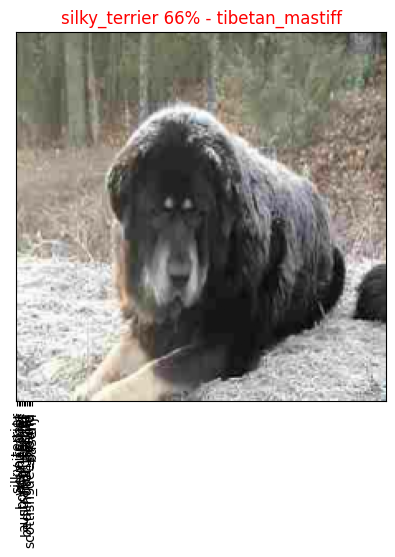

In [32]:
images, labels = ExtractBatch(validation_data)
index = 100
ValidatePrediction(predictions[index], labels[index], images[index])
ValidateTop10Predictions(predictions[index], labels[index])

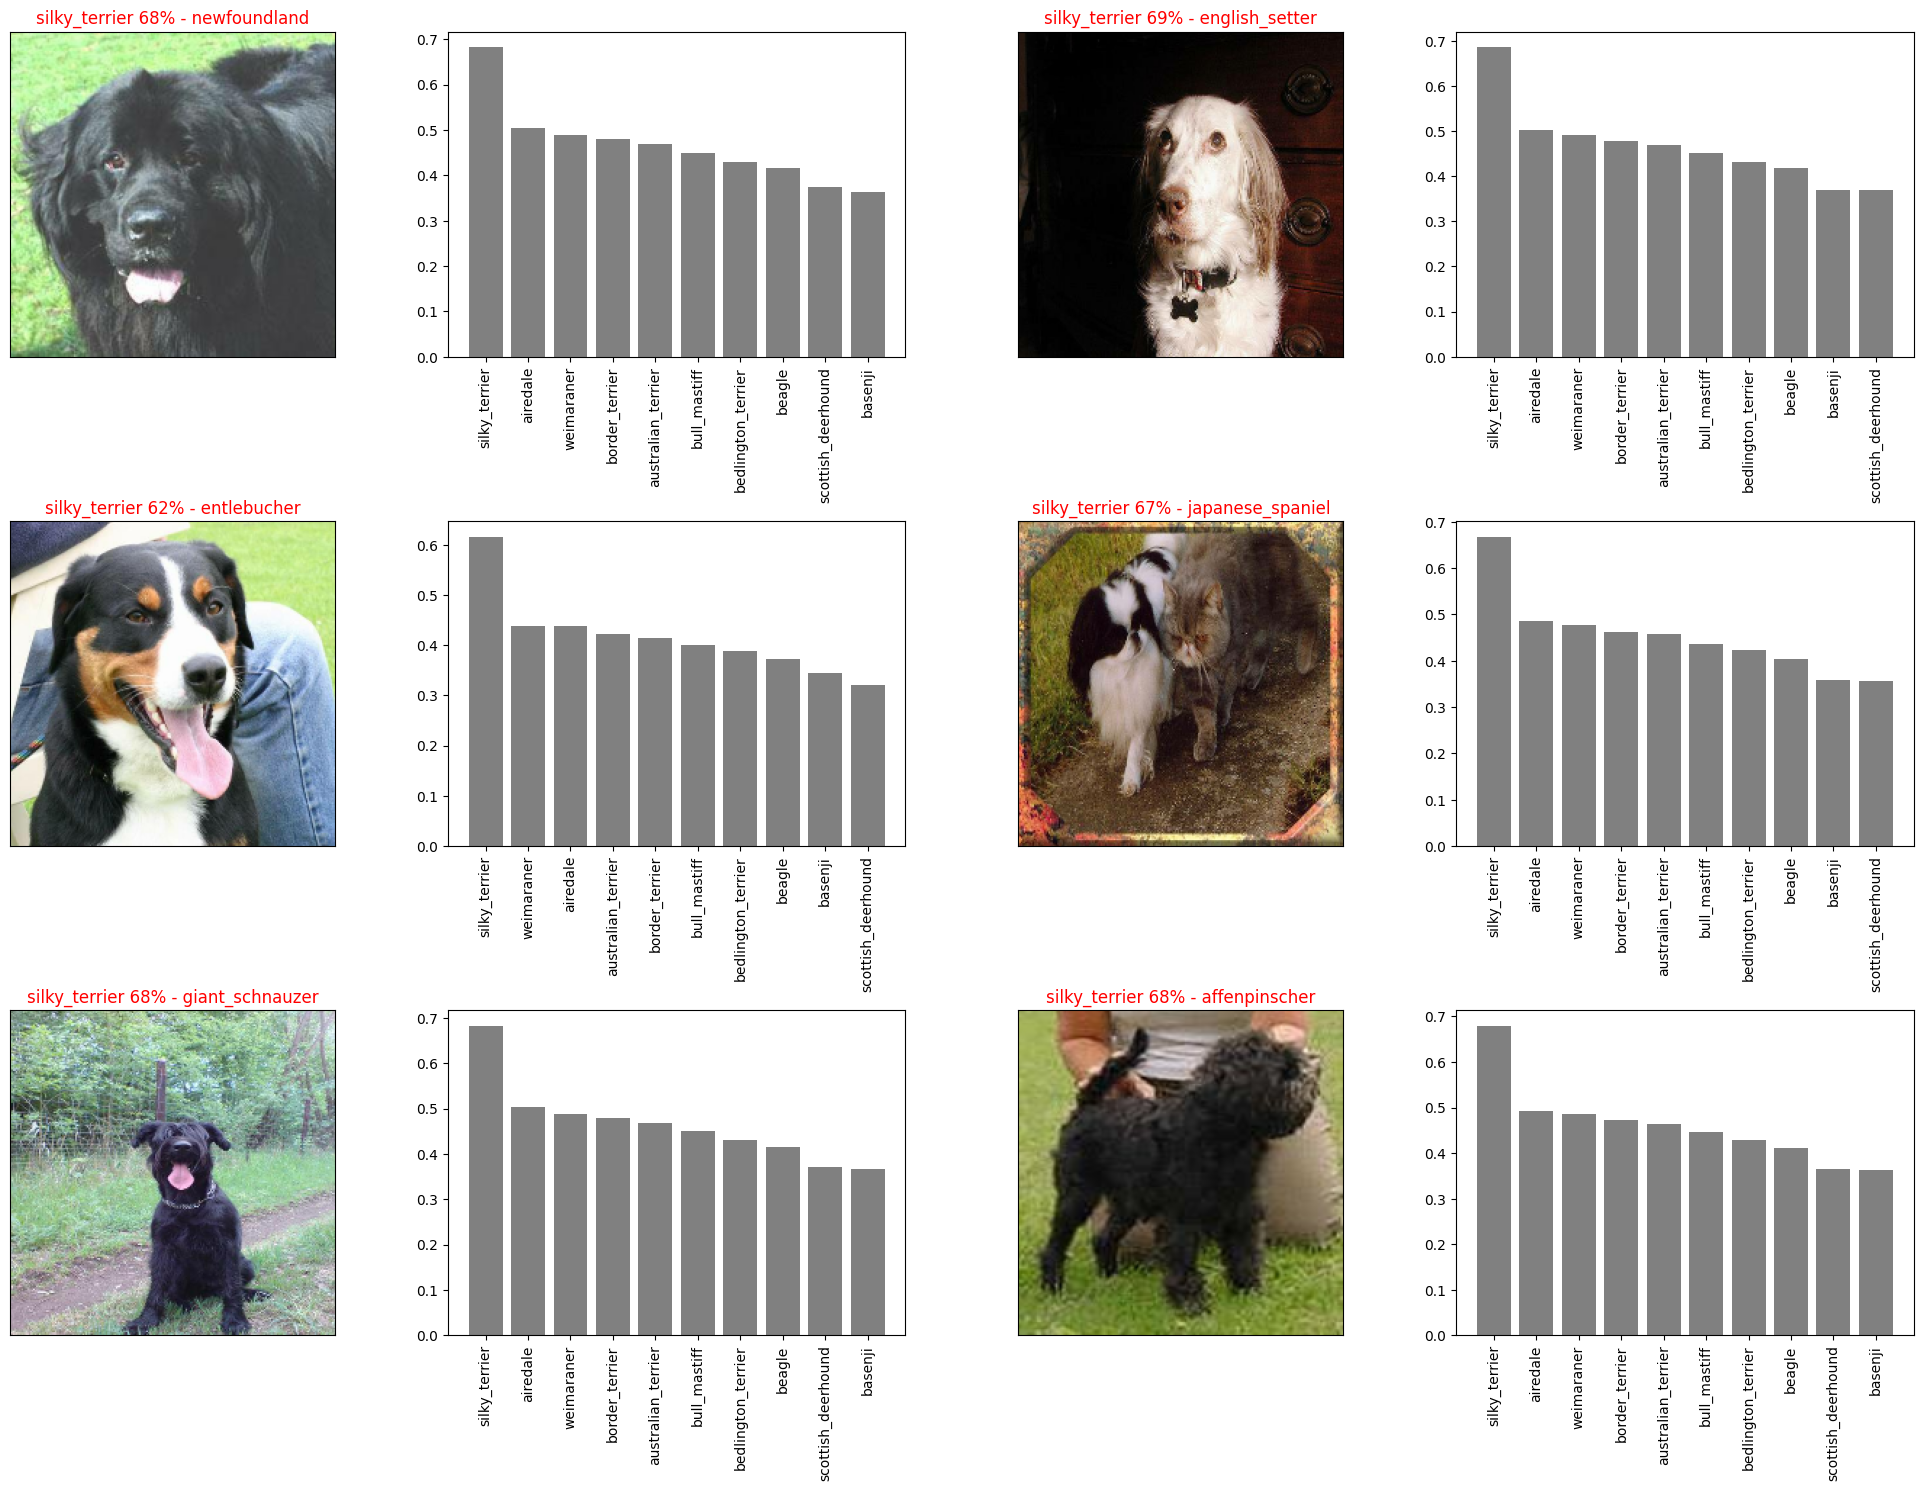

In [33]:
# Let's check a few predictions and their different values
offset = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  ValidatePrediction(predictions[i+offset],
            labels[i+offset],
            images[i+offset],
            )
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  ValidateTop10Predictions(predictions[i+offset],
                labels[i+offset])
plt.tight_layout(h_pad=1.0)
plt.show()

6 layers
model 0: input_layer_2
model 1: sequential_1
model 2: MobileNetV3Large
model 3: AveragePooling
model 4: FinalDropout
model 5: dense
base_model.name: MobileNetV3Large
Number of layers in the base model:  187
Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 39s 123ms/step - accuracy: 0.0125 - loss: 4.7921 - val_accuracy: 0.0117 - val_loss: 4.7969
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.0128 - loss: 4.7844 - val_accuracy: 0.0117 - val_loss: 4.7936
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.0125 - loss: 4.7829 - val_accuracy: 0.0117 - val_loss: 4.7940
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.0119 - loss: 4.7837 - val_accuracy: 0.0117 - val_loss: 4.7933
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.0124 - loss: 4.7821 - val_accuracy: 0.0117 - val_loss: 4.7922
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.0119 - loss: 4.7818 - val_accuracy: 0.0117 - val_loss: 4.791

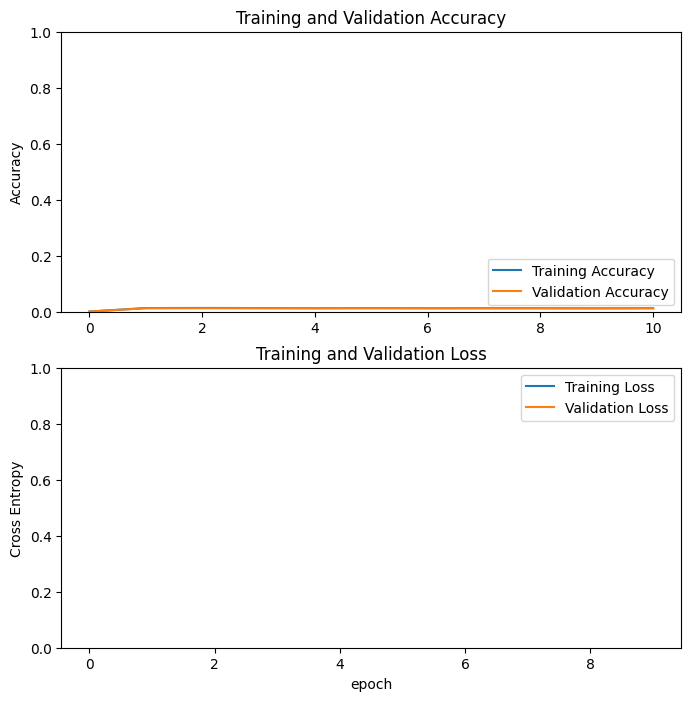

In [24]:
# Fine-tune the model
nb_layers = len(model.layers)
print(f"{nb_layers} layers")

for i in range(nb_layers):
    print(f"model {i}: {model.layers[i].name}")

base_model = model.layers[-4] # MobileNetV3Large
print(f"base_model.name: {base_model.name}")
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
# Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.
fine_tune_at = len(base_model.layers) - 30

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(0.1 * base_learning_rate),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x=train_data, epochs=NUM_EPOCHS, validation_data=validation_data, validation_freq=1, callbacks=[tensorboard])
PlotModelPerformance(history)

In [31]:
# Save model
def SaveModel(model, suffix:str = None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models", datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".keras" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

def LoadModel(path: str):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {path}")
  model = tf.keras.models.load_model(path, custom_objects={"KerasLayer": hub.KerasLayer}) # custom_objects:	Optional dictionary mapping names (strings) to custom classes or functions to be considered during deserialization.
  return model  

In [33]:
SaveModel(model, "mobilenet-v2-140-224-classification")
model = LoadModel(...)
model.evaluate(validation_data)

NameError: name 'model' is not defined

# Train on complete dataset

In [ ]:
# Train on complete dataset
len(X), len(Y)
train_data = create_data_batches(X, Y, BATCH_SIZE)
train_data
#model = CreateModel()
#model.summary()
tensorboard = CreateTensorBoardCallback()
circuit_breaker = CreateCircuitBreakerCallback("accuracy") # Since we don't have the validation dataset
model.fit(x=train_data,epochs=NUM_EPOCHS, callbacks=[tensorboard, circuit_breaker])

Create training data batches...


TypeError: CreateModel() missing 3 required positional arguments: 'image_shape', 'output_shape', and 'data_augmentation'

In [ ]:
# Make predictions on test dataset
test_path = "data/dog-breed-identification/test"
test_filenames = [f"{test_path}/{f}" for f in os.listdir(test_path)]
len(test_filenames)
test_filenames[:10]
test_data = create_data_batches(test_filenames, None, BATCH_SIZE, isTest=True)
test_data.element_spec # TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)
predictions = model.predict(test_data, verbose=1) # verbose shows us how long there is to go
numpy.savetxt(f"{test_path}/predictions.csv", predictions, delimiter=",")

Create test data batches...
322/324 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

2025-09-28 15:25:16.564539: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-28 15:25:16.683670: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-28 15:25:16.796429: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-28 15:25:16.916234: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


324/324 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step


In [60]:
# Kaggle submission format
# id,affenpinscher,afghan_hound,..,yorkshire_terrier
# 000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
# id is the test/{id}.jpg
kaggle_data = pd.DataFrame(columns=["id"] + list(unique_breeds))
#kaggle_data.head()
# Extract ids from path
kaggle_data.id = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
kaggle_data[list(unique_breeds)] = predictions
kaggle_data.head()
kaggle_data.to_csv(f"{test_path}/kaggle_submission.csv", index=False)

NameError: name 'predictions' is not defined